# 2つの確率分布を比較するKL_DivergenceとCross_Entropy

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
save = False

## 確率分布

2つの確率分布P(x), Q(x)を用意する

- ## P(x)   $(\mu = 0, \sigma = 2.5)$
- ## Q(x)   $(\mu = 3, \sigma = 2)$

In [15]:
mean_p, vari_p= 0, 2.5
mean_q, vari_q= 3, 2
P = lambda x: (np.e**-(((x-mean_p)**2)/(2*vari_p)))/(2*np.pi*vari_p)**0.5
Q = lambda x: (np.e**-(((x-mean_q)**2)/(2*vari_q)))/(2*np.pi*vari_q)**0.5

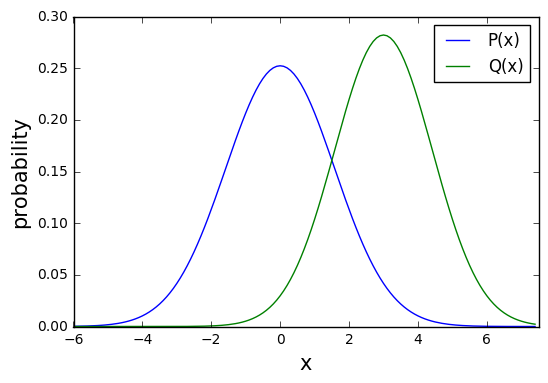

In [16]:
x_min, x_max = -6, 7.5
x = np.arange(x_min,x_max,0.1)
plt.plot(x,P(x),label="P(x)")
plt.plot(x,Q(x),label="Q(x)")
plt.legend()
plt.xlim(x_min,x_max)
plt.xlabel("x",fontsize=15)
plt.ylabel("probability",fontsize=15)
if save: plt.savefig("prob")

## 情報量

## $I_{p} = - log{P(x)} $
## $I_{q} = - log{Q(x)} $

In [17]:
I = lambda p: -np.log(p)

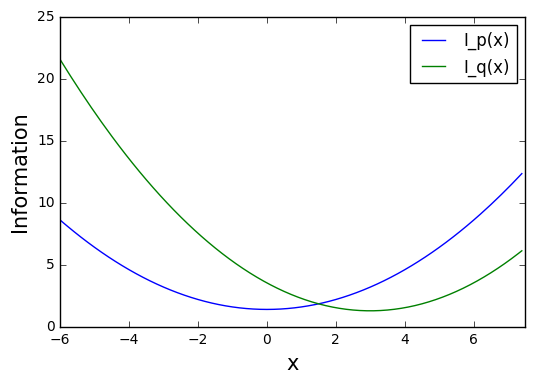

In [18]:
# x_min, x_max = -4, 6.5
x = np.arange(x_min,x_max,0.1)
plt.plot(x,I(P(x)),label="I_p(x)")
plt.plot(x,I(Q(x)),label="I_q(x)")
plt.legend()
plt.xlim(x_min,x_max)
plt.xlabel("x",fontsize=15)
plt.ylabel("Information",fontsize=15)
if save: plt.savefig("info")

## 情報量の差分

Q(x)からP(x)に変わるために伝達する必要最小限の情報量

## $ D(x) = I_{q} - I_{p} = log\frac{P(x)}{Q(x)} $

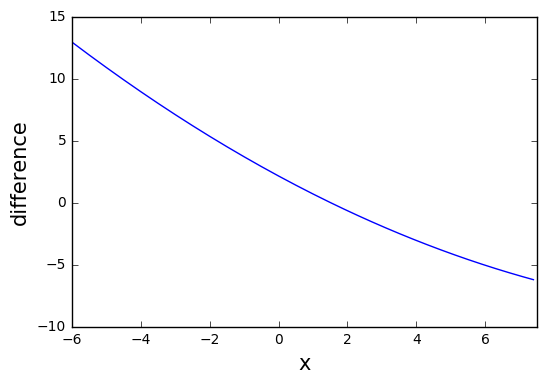

In [19]:
# x_min, x_max = -4, 6.5
x = np.arange(x_min,x_max,0.1)
plt.plot(x,I(Q(x))-I(P(x)))
plt.xlim(x_min,x_max)
plt.xlabel("x",fontsize=15)
plt.ylabel("difference",fontsize=15)
if save: plt.savefig("diff")

## Kullback–Leibler Divergence

- 重み付き差分
## $ WD(x) = P(x) D(x) $
- KL_Divergence
## $ D_{KL} = \int WD(x) dx = \int P(x) log\frac{P(x)}{Q(x)} dx$

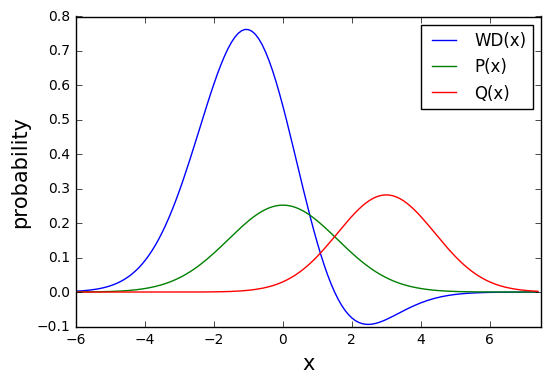

In [20]:
# x_min, x_max = -4, 6.5
x = np.arange(x_min,x_max,0.1)
plt.plot(x,P(x)*(I(Q(x))-I(P(x))),label="WD(x)")
plt.plot(x,P(x),label="P(x)")
plt.plot(x,Q(x),label="Q(x)")
plt.legend()
plt.xlim(x_min,x_max)
plt.xlabel("x",fontsize=15)
plt.ylabel("probability",fontsize=15)
if save: plt.savefig("wd_p")

### 真の確率分布P(x)にMachine Learningの推定分布Q(x)を近づけるには

## $ \underset{Q}{\operatorname{argmin}} D_{KL} \\
= \underset{Q}{\operatorname{argmin}} \{ \int P(x) log\frac{P(x)}{Q(x)} dx \} \\
= \underset{Q}{\operatorname{argmin}} \{-\int P(x) logQ(x) dx \} $

## KL_Divergenceの最小値を求めることは、CrossEntropyを求めることと同義

## $ D_{KL} = \int P(x) logP(x) dx  +  CrossEntropy $ 


## さらに One Hot の場合は 
## $\int P(x) logP(x) dx = 0 \\
D_{KL} = CrossEntropy$

In [139]:
y_true = np.asarray([0, 0, 0, 1])
y_pred = np.asarray([0.3, 0.2, 0.49, 0.01])
y_true = K.variable(y_true)
y_pred = K.variable(y_pred)
y_true = K.clip(y_true, K.epsilon(), 1)
y_pred = K.clip(y_pred, K.epsilon(), 1)

kl_loss = K.sum(y_true * K.log(y_true / y_pred), axis=-1)
cross_entropy_loss = K.sum(-y_true * K.log(y_pred), axis=-1)
print('kl_loss: ', K.get_value(kl_loss))
print('cross_entropy: ', K.get_value(cross_entropy_loss))

kl_loss:  4.60517
cross_entropy:  4.60517


In [141]:
K.get_value(K.log(0.01))

-4.6051702

# 自作 KL_Divergence Loss で MNISTクラス分け

In [143]:
import tensorflow as tf
import keras

from keras.datasets import mnist
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import RMSprop

print('tensorflow: ', tf.__version__)
print('keras: ', keras.__version__)

# MNISTデータを読込む
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# MNISTデータを加工する
x_train  = x_train.reshape(60000, 784)
x_test   = x_test.reshape(10000, 784)
x_train  = x_train.astype('float32')
x_test   = x_test.astype('float32')
x_train /= 255
x_test  /= 255
y_train  = keras.utils.to_categorical(y_train, 10)
y_test   = keras.utils.to_categorical(y_test, 10)

def build_model(loss_function):
    # モデルの構築
    inputs = Input(shape=(784,))
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(10, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss=loss_function, optimizer='sgd', metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=128, epochs=30, verbose=0, validation_data=(x_test, y_test))
    return history

def build_ae_model(loss_function, epochs=30):
    encoding_dim = 32
    input_img = Input(shape=(784,))
    encoded = Dense(128, activation='relu')(input_img)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(encoding_dim, activation='relu')(encoded)

    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(784, activation='sigmoid')(decoded)

    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(loss=loss_function, optimizer='adam', metrics=['accuracy'])
    history = autoencoder.fit(x_train, x_train, batch_size=128, epochs=epochs, verbose=0, validation_data=(x_test, x_test))
    return history, autoencoder

tensorflow:  1.4.0
keras:  2.0.9


In [86]:
def kullback_leibler_divergence(y_true, y_pred):
    # 0 に近い値を小さい値に置き換えることで、発散しないようにする
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    return K.sum(y_true * K.log(y_true / y_pred), axis=-1)

## [補足] K.epsilonとK.clipの使い方

In [10]:
import numpy as np

print('epsilon: ', K.epsilon())
A = np.asarray([
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]
    ])
A = K.variable(A)
# 最小値と最大値を設定する
K.get_value(K.clip(A, 2, 5))

epsilon:  1e-07


array([[ 2.,  2.,  3.],
       [ 4.,  5.,  5.],
       [ 5.,  5.,  5.]], dtype=float32)

In [53]:
kl_loss_history = build_model(kullback_leibler_divergence)
crossentropy_loss_history = build_model('categorical_crossentropy')
mean_squared_loss_history = build_model('mean_squared_error')

In [144]:
def plot_history(kl_loss_history, crossentropy_loss_history, mean_squared_loss_history, acc=True, loss=True):
    # 精度の履歴をプロット
    if acc:
        plt.plot(kl_loss_history.history['acc'], "o-", label="kl_accuracy")
        plt.plot(kl_loss_history.history['val_acc'], "o-", label="kl_validation_accuracy")

        plt.plot(crossentropy_loss_history.history['acc'], "o-", label="crossentropy_accuracy")
        plt.plot(crossentropy_loss_history.history['val_acc'], "o-", label="crossentropy_validation_accuracy")

        plt.plot(mean_squared_loss_history.history['acc'], "o-", label="mean_squared_accuracy")
        plt.plot(mean_squared_loss_history.history['val_acc'], "o-", label="mean_squared_validation_accuracy")
        plt.title('model accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1.05])
        plt.legend(loc="lower right")
        plt.show()

    # 損失の履歴をプロット
    if loss:
        plt.plot(kl_loss_history.history['loss'],"o-",label="kl_loss",)
        plt.plot(kl_loss_history.history['val_loss'], "o-", label="kl_validation_loss")

        plt.plot(crossentropy_loss_history.history['loss'],"o-",label="crossentropy_loss",)
        plt.plot(crossentropy_loss_history.history['val_loss'], "o-", label="crossentropy_validation_loss")

        plt.plot(mean_squared_loss_history.history['loss'],"o-",label="mean_squared_loss",)
        plt.plot(mean_squared_loss_history.history['val_loss'], "o-", label="mean_squared_validation_loss")

        plt.title('model loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.show()

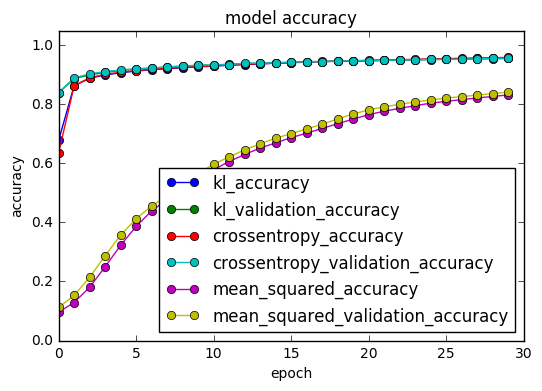

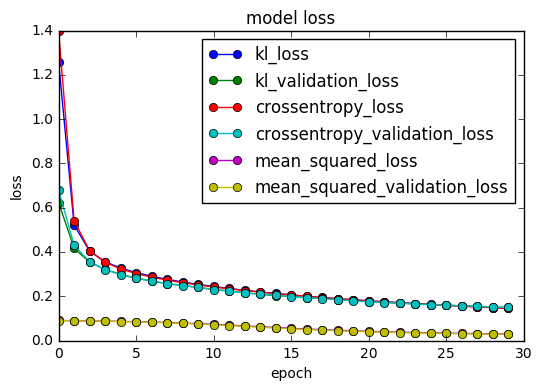

In [55]:
plot_history(kl_loss_history, crossentropy_loss_history, mean_squared_loss_history)

## クラス分類は mean squared よりも KL Divergence の方が収束が早い

# MNISTでAutoEncoder (KL,CrossEntropy, MeanSquared)

In [91]:
kl_loss_history, kl_model = build_ae_model('kullback_leibler_divergence')
crossentropy_loss_history, crossentropy_model = build_ae_model('categorical_crossentropy')
mean_squared_loss_history, mean_squared_model = build_ae_model('mean_squared_error')

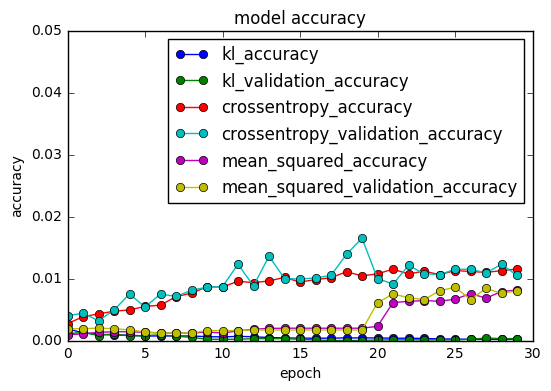

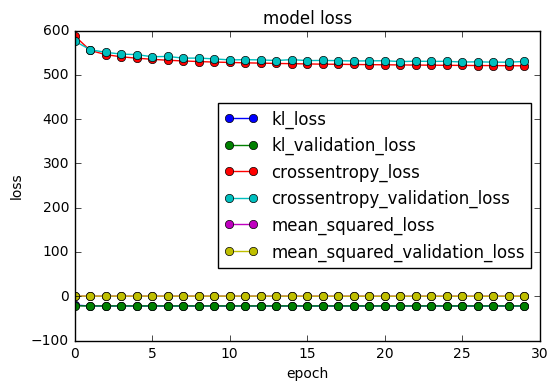

In [107]:
# 精度の履歴をプロット

plt.plot(kl_loss_history.history['acc'], "o-", label="kl_accuracy")
plt.plot(kl_loss_history.history['val_acc'], "o-", label="kl_validation_accuracy")

plt.plot(crossentropy_loss_history.history['acc'], "o-", label="crossentropy_accuracy")
plt.plot(crossentropy_loss_history.history['val_acc'], "o-", label="crossentropy_validation_accuracy")

plt.plot(mean_squared_loss_history.history['acc'], "o-", label="mean_squared_accuracy")
plt.plot(mean_squared_loss_history.history['val_acc'], "o-", label="mean_squared_validation_accuracy")
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 0.05])
plt.legend()
plt.show()

# 損失の履歴をプロット

plt.plot(kl_loss_history.history['loss'],"o-",label="kl_loss",)
plt.plot(kl_loss_history.history['val_loss'], "o-", label="kl_validation_loss")

plt.plot(crossentropy_loss_history.history['loss'],"o-",label="crossentropy_loss",)
plt.plot(crossentropy_loss_history.history['val_loss'], "o-", label="crossentropy_validation_loss")

plt.plot(mean_squared_loss_history.history['loss'],"o-",label="mean_squared_loss",)
plt.plot(mean_squared_loss_history.history['val_loss'], "o-", label="mean_squared_validation_loss")

plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="best")
plt.show()

## KL_Divergence は CrossEntropyとLossが同じでもAccuracyが低い
Lossの計算が

In [92]:
# show original image and reconstructed image
def showOrigDec(orig, dec, num=10):
    n = num
    plt.figure(figsize=(20, 4))
    image_shape = (28, 28)

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(image_shape))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[i].reshape(image_shape))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [93]:
kl_generated = kl_model.predict(x_train[:10])
crossentropy_generated = crossentropy_model.predict(x_train[:10])
mean_squared_generated = mean_squared_model.predict(x_train[:10])

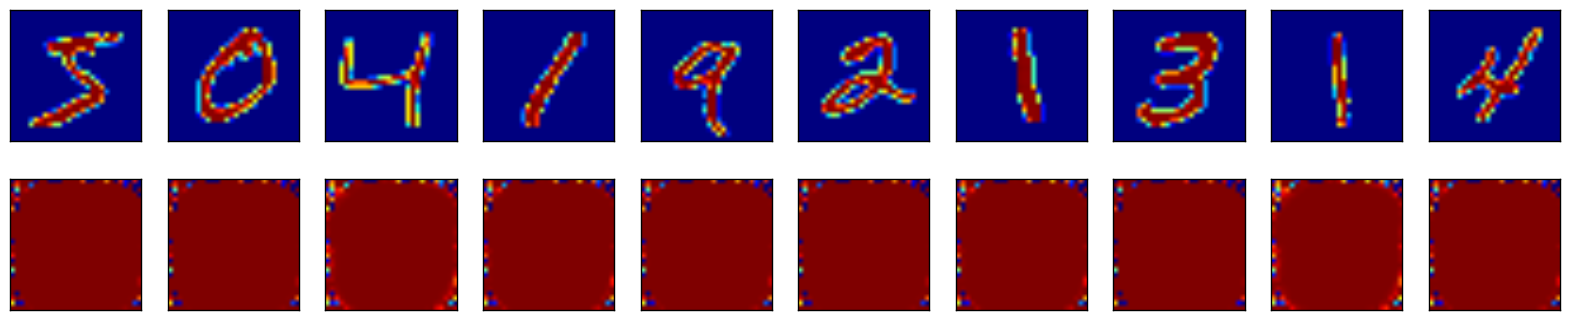

In [94]:
showOrigDec(x_train[:10], kl_generated)

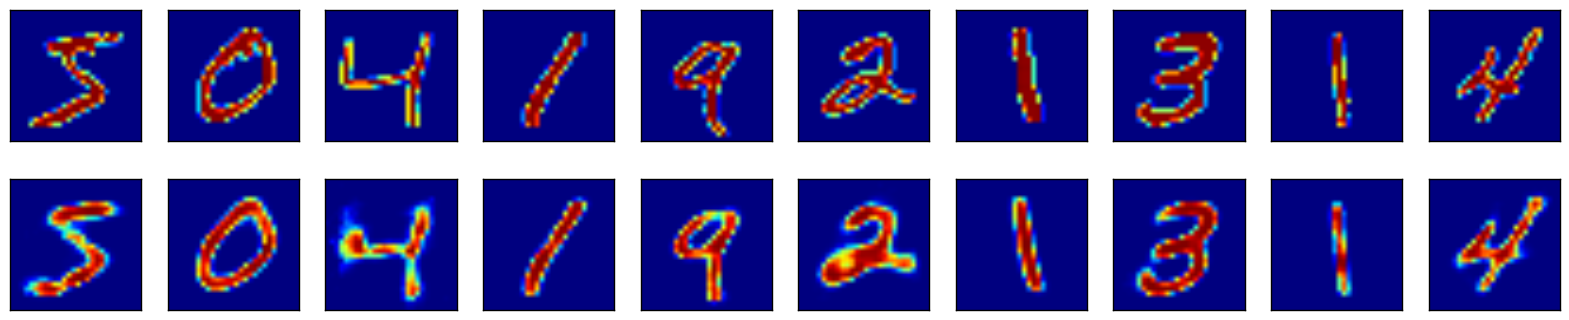

In [89]:
showOrigDec(x_train[:10], crossentropy_generated)

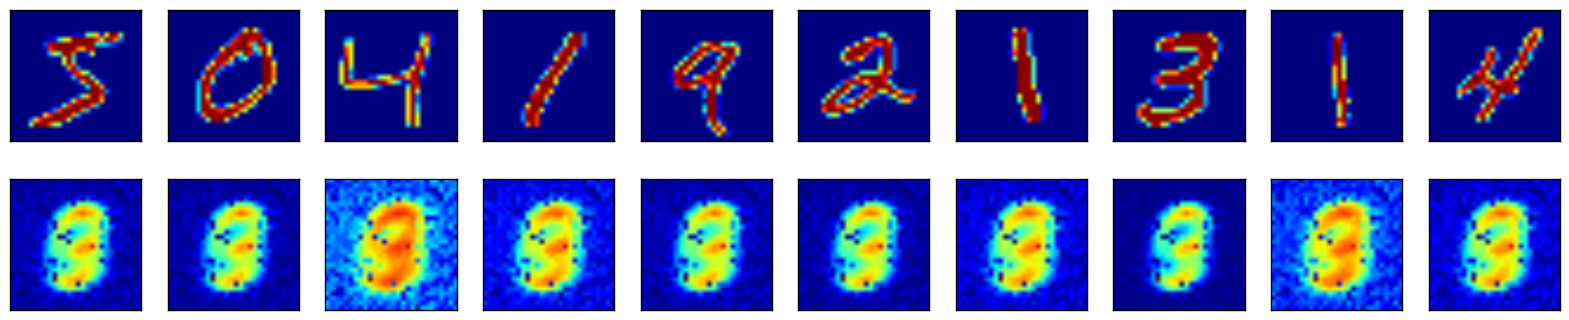

In [90]:
showOrigDec(x_train[:10], mean_squared_generated)

In [109]:
kl_loss_history, kl_model = build_ae_model('kullback_leibler_divergence', epochs = 50)
crossentropy_loss_history, crossentropy_model = build_ae_model('categorical_crossentropy', epochs = 50)
mean_squared_loss_history, mean_squared_model = build_ae_model('mean_squared_error', epochs = 50)

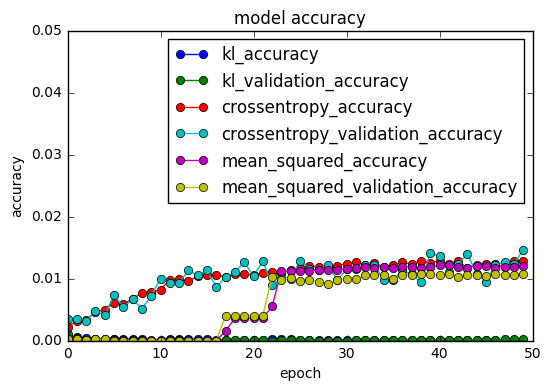

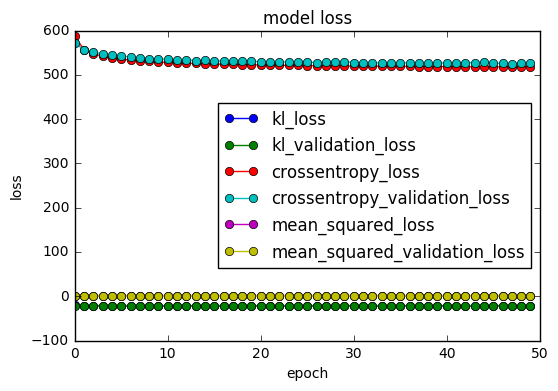

In [110]:
# 精度の履歴をプロット

plt.plot(kl_loss_history.history['acc'], "o-", label="kl_accuracy")
plt.plot(kl_loss_history.history['val_acc'], "o-", label="kl_validation_accuracy")

plt.plot(crossentropy_loss_history.history['acc'], "o-", label="crossentropy_accuracy")
plt.plot(crossentropy_loss_history.history['val_acc'], "o-", label="crossentropy_validation_accuracy")

plt.plot(mean_squared_loss_history.history['acc'], "o-", label="mean_squared_accuracy")
plt.plot(mean_squared_loss_history.history['val_acc'], "o-", label="mean_squared_validation_accuracy")
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 0.05])
plt.legend()
plt.show()

# 損失の履歴をプロット

plt.plot(kl_loss_history.history['loss'],"o-",label="kl_loss",)
plt.plot(kl_loss_history.history['val_loss'], "o-", label="kl_validation_loss")

plt.plot(crossentropy_loss_history.history['loss'],"o-",label="crossentropy_loss",)
plt.plot(crossentropy_loss_history.history['val_loss'], "o-", label="crossentropy_validation_loss")

plt.plot(mean_squared_loss_history.history['loss'],"o-",label="mean_squared_loss",)
plt.plot(mean_squared_loss_history.history['val_loss'], "o-", label="mean_squared_validation_loss")

plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="best")
plt.show()

## Lossが小さすぎると学習できない？

In [114]:
kl_generated = kl_model.predict(x_train[:10])
crossentropy_generated = crossentropy_model.predict(x_train[:10])
mean_squared_generated = mean_squared_model.predict(x_train[:10])

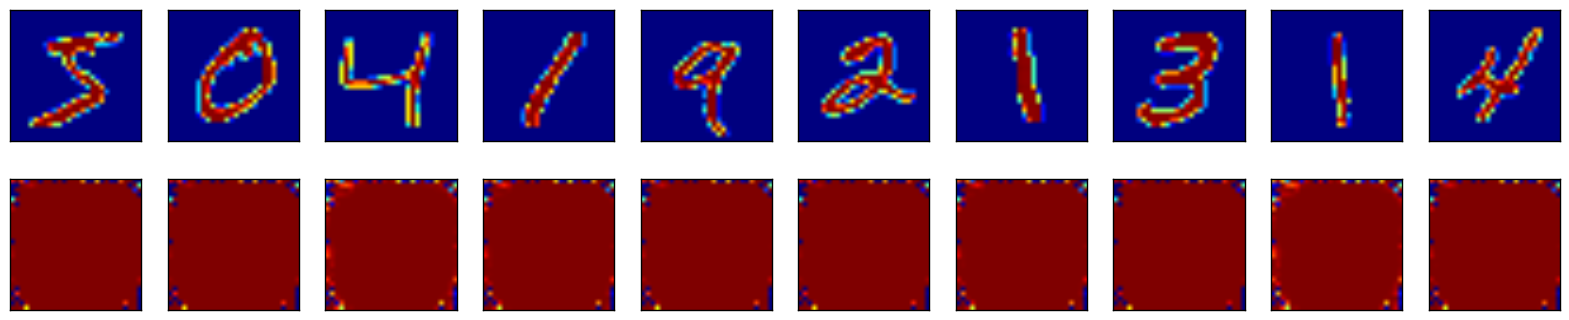

In [115]:
showOrigDec(x_train[:10], kl_generated)

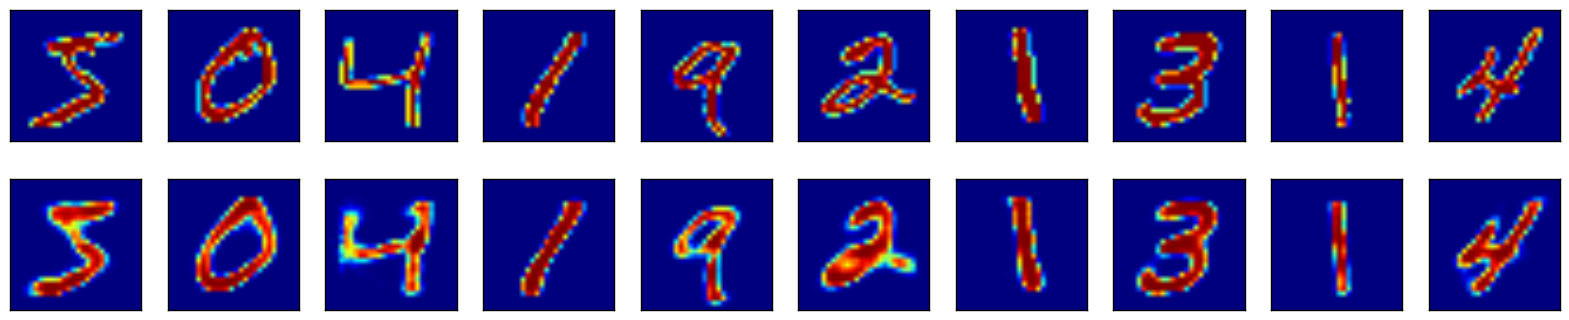

In [116]:
showOrigDec(x_train[:10], crossentropy_generated)

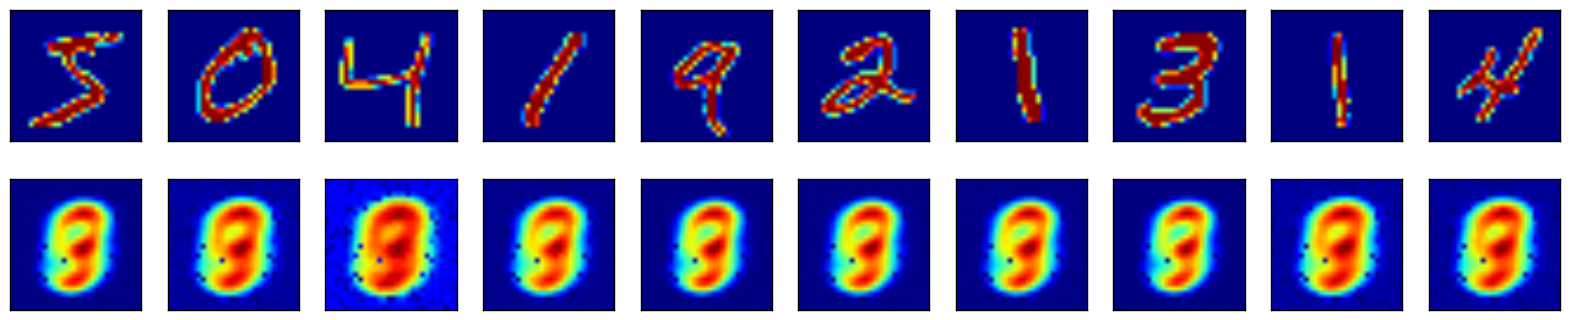

In [117]:
showOrigDec(x_train[:10], mean_squared_generated)

In [118]:
# MNISTデータを読込む
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# MNISTデータを加工する
x_train  = x_train.reshape(60000, 784)
x_test   = x_test.reshape(10000, 784)
x_train  = x_train.astype('float32')
x_test   = x_test.astype('float32')

In [119]:
mean_squared_loss_history, mean_squared_model = build_ae_model('mean_squared_error', epochs = 50)

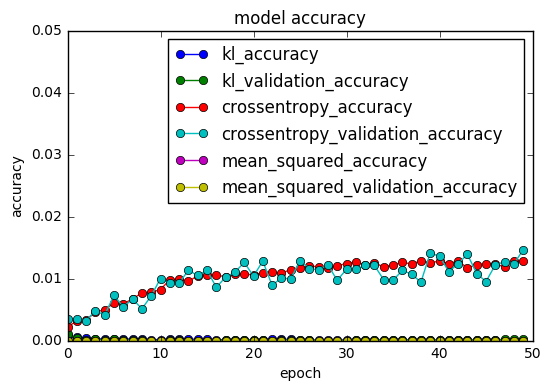

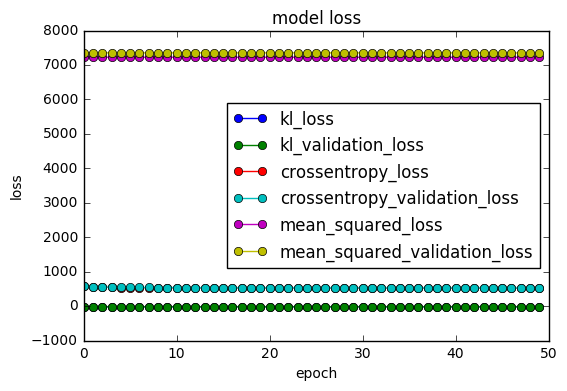

In [120]:
# 精度の履歴をプロット

plt.plot(kl_loss_history.history['acc'], "o-", label="kl_accuracy")
plt.plot(kl_loss_history.history['val_acc'], "o-", label="kl_validation_accuracy")

plt.plot(crossentropy_loss_history.history['acc'], "o-", label="crossentropy_accuracy")
plt.plot(crossentropy_loss_history.history['val_acc'], "o-", label="crossentropy_validation_accuracy")

plt.plot(mean_squared_loss_history.history['acc'], "o-", label="mean_squared_accuracy")
plt.plot(mean_squared_loss_history.history['val_acc'], "o-", label="mean_squared_validation_accuracy")
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 0.05])
plt.legend()
plt.show()

# 損失の履歴をプロット

plt.plot(kl_loss_history.history['loss'],"o-",label="kl_loss",)
plt.plot(kl_loss_history.history['val_loss'], "o-", label="kl_validation_loss")

plt.plot(crossentropy_loss_history.history['loss'],"o-",label="crossentropy_loss",)
plt.plot(crossentropy_loss_history.history['val_loss'], "o-", label="crossentropy_validation_loss")

plt.plot(mean_squared_loss_history.history['loss'],"o-",label="mean_squared_loss",)
plt.plot(mean_squared_loss_history.history['val_loss'], "o-", label="mean_squared_validation_loss")

plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="best")
plt.show()

## SGD => Adam にして、学習速度を自動で最適化する場合は

In [145]:
kl_loss_history, kl_model = build_ae_model('kullback_leibler_divergence')
crossentropy_loss_history, crossentropy_model = build_ae_model('categorical_crossentropy')
mean_squared_loss_history, mean_squared_model = build_ae_model('mean_squared_error')

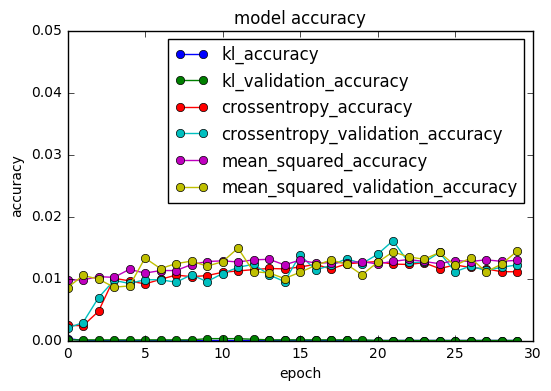

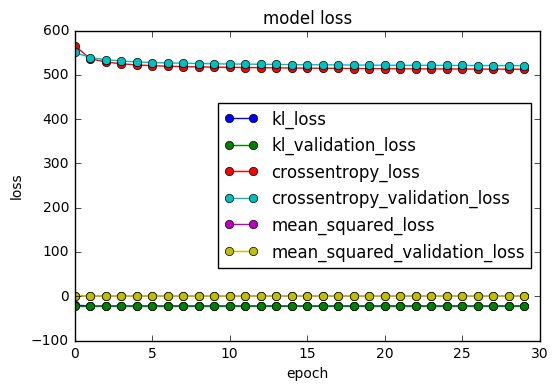

In [146]:
# 精度の履歴をプロット

plt.plot(kl_loss_history.history['acc'], "o-", label="kl_accuracy")
plt.plot(kl_loss_history.history['val_acc'], "o-", label="kl_validation_accuracy")

plt.plot(crossentropy_loss_history.history['acc'], "o-", label="crossentropy_accuracy")
plt.plot(crossentropy_loss_history.history['val_acc'], "o-", label="crossentropy_validation_accuracy")

plt.plot(mean_squared_loss_history.history['acc'], "o-", label="mean_squared_accuracy")
plt.plot(mean_squared_loss_history.history['val_acc'], "o-", label="mean_squared_validation_accuracy")
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 0.05])
plt.legend()
plt.show()

# 損失の履歴をプロット

plt.plot(kl_loss_history.history['loss'],"o-",label="kl_loss",)
plt.plot(kl_loss_history.history['val_loss'], "o-", label="kl_validation_loss")

plt.plot(crossentropy_loss_history.history['loss'],"o-",label="crossentropy_loss",)
plt.plot(crossentropy_loss_history.history['val_loss'], "o-", label="crossentropy_validation_loss")

plt.plot(mean_squared_loss_history.history['loss'],"o-",label="mean_squared_loss",)
plt.plot(mean_squared_loss_history.history['val_loss'], "o-", label="mean_squared_validation_loss")

plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="best")
plt.show()

In [147]:
kl_generated = kl_model.predict(x_train[:10])
crossentropy_generated = crossentropy_model.predict(x_train[:10])
mean_squared_generated = mean_squared_model.predict(x_train[:10])

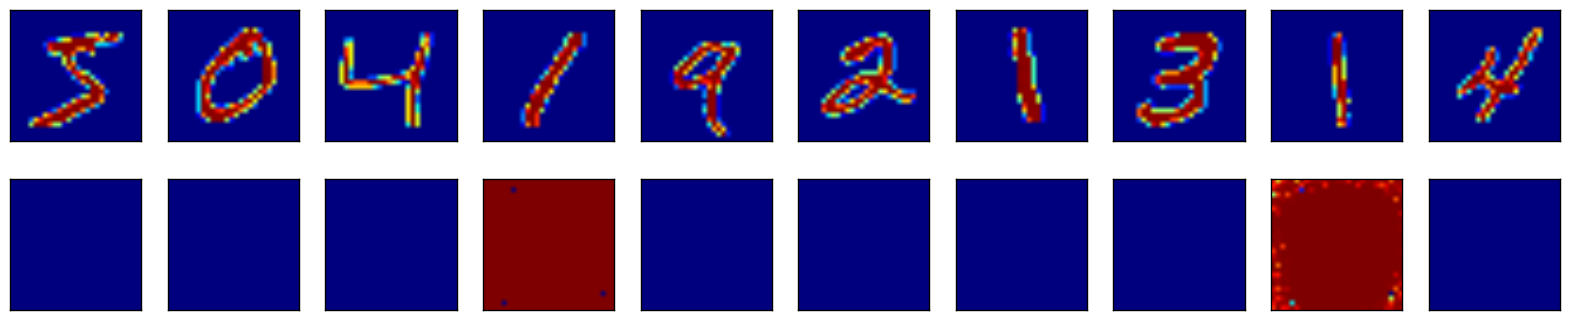

In [148]:
showOrigDec(x_train[:10], kl_generated)

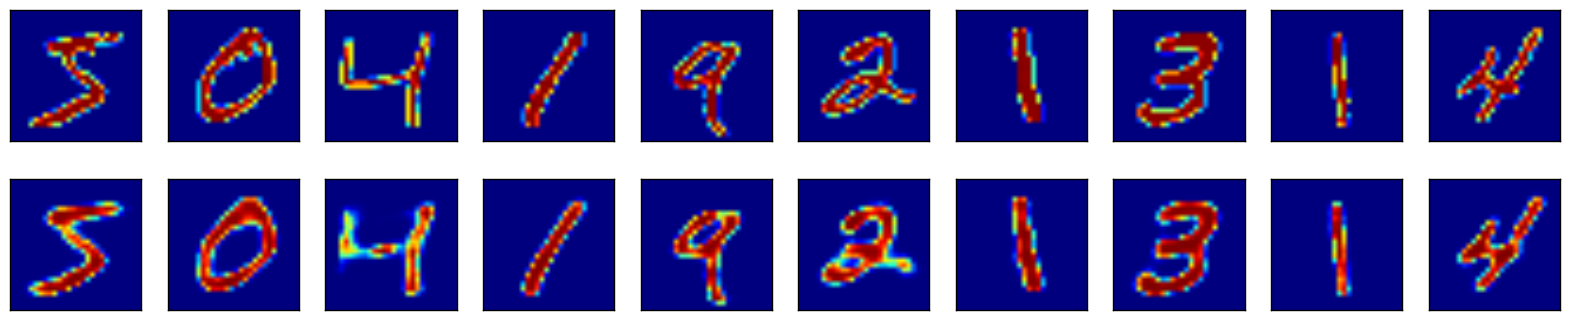

In [149]:
showOrigDec(x_train[:10], crossentropy_generated)

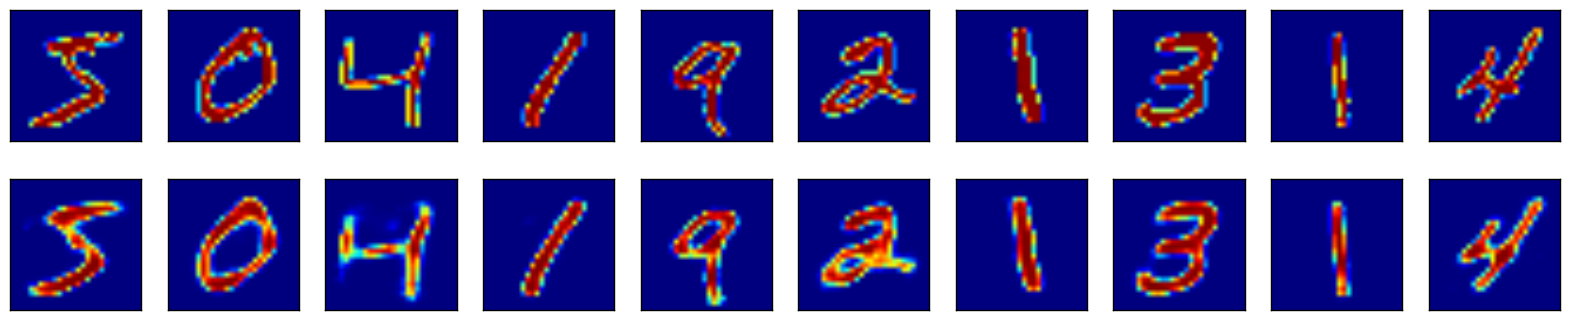

In [150]:
showOrigDec(x_train[:10], mean_squared_generated)

In [151]:
# MNISTデータを読込む
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# MNISTデータを加工する
x_train  = x_train.reshape(60000, 784)
x_test   = x_test.reshape(10000, 784)
x_train  = x_train.astype('float32')
x_test   = x_test.astype('float32')

In [153]:
mean_squared_raw_loss_history, mean_squared_raw_model = build_ae_model('mean_squared_error')

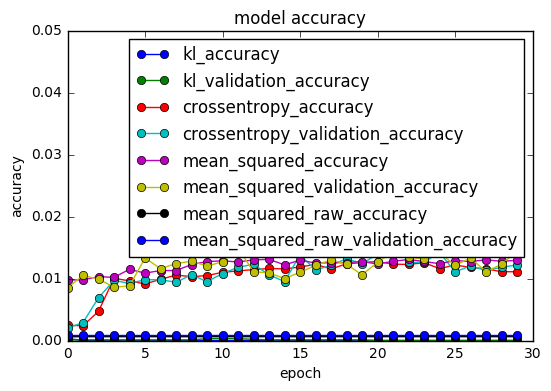

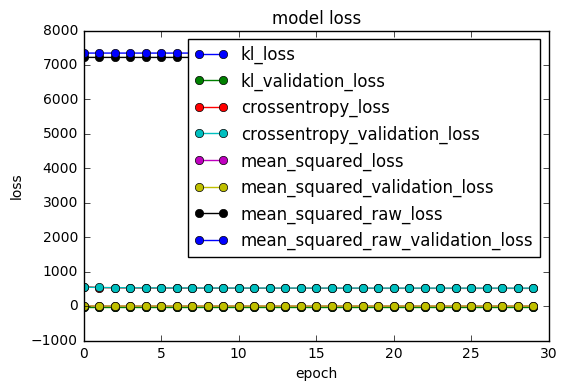

In [155]:
# 精度の履歴をプロット

plt.plot(kl_loss_history.history['acc'], "o-", label="kl_accuracy")
plt.plot(kl_loss_history.history['val_acc'], "o-", label="kl_validation_accuracy")

plt.plot(crossentropy_loss_history.history['acc'], "o-", label="crossentropy_accuracy")
plt.plot(crossentropy_loss_history.history['val_acc'], "o-", label="crossentropy_validation_accuracy")

plt.plot(mean_squared_loss_history.history['acc'], "o-", label="mean_squared_accuracy")
plt.plot(mean_squared_loss_history.history['val_acc'], "o-", label="mean_squared_validation_accuracy")

plt.plot(mean_squared_raw_loss_history.history['acc'], "o-", label="mean_squared_raw_accuracy")
plt.plot(mean_squared_raw_loss_history.history['val_acc'], "o-", label="mean_squared_raw_validation_accuracy")

plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 0.05])
plt.legend()
plt.show()

# 損失の履歴をプロット

plt.plot(kl_loss_history.history['loss'],"o-",label="kl_loss",)
plt.plot(kl_loss_history.history['val_loss'], "o-", label="kl_validation_loss")

plt.plot(crossentropy_loss_history.history['loss'],"o-",label="crossentropy_loss",)
plt.plot(crossentropy_loss_history.history['val_loss'], "o-", label="crossentropy_validation_loss")

plt.plot(mean_squared_loss_history.history['loss'],"o-",label="mean_squared_loss",)
plt.plot(mean_squared_loss_history.history['val_loss'], "o-", label="mean_squared_validation_loss")

plt.plot(mean_squared_raw_loss_history.history['loss'],"o-",label="mean_squared_raw_loss",)
plt.plot(mean_squared_raw_loss_history.history['val_loss'], "o-", label="mean_squared_raw_validation_loss")

plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="best")
plt.show()

## 流石に正規化しないとLossに埋もれてAdamでも学習できない

##  結論

- KL Divergence : 2つの確率分布の距離を比較する
- KL Divergenceを最小にすること <=> CrossEntropyを最小にすること
- 真の分布がOneHotなら、KL Divergence = CrossEntropy
- mean squared loss は 設計次第で大きすぎたり、小さすぎたりするLossで学習係数の設計が難しい
- KL Divergence も Lossにするには小さすぎるどころか、負の値をとってしまう
- Lossの絶対値の大きさが心配ならOptimizerはAdamにしろ！
- 正規化は大事！